In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from scipy.stats import pearsonr

print("Correlation Analysis - Implementing Assessment Criteria")

Correlation Analysis - Implementing Assessment Criteria


In [2]:
# Load and prepare data for correlation analysis
print("Loading news and stock data...")

# Load news data with correct columns
news_df = pd.read_csv(r'C:\Users\admin\finaniacal-week1\data\raw_analyst_ratings.csv')
print(f"News data loaded: {len(news_df)} records")
print("News columns:", news_df.columns.tolist())

# Load stock data with correct columns  
stock_df = pd.read_csv(r'C:\Users\admin\finaniacal-week1\data\NVDA.csv')
print(f"Stock data loaded: {len(stock_df)} records")
print("Stock columns:", stock_df.columns.tolist())

# Display sample data
print("\nNews data sample:")
display(news_df[['headline', 'date', 'publisher']].head())

print("\nStock data sample:")
display(stock_df[['Date', 'Close']].head())

Loading news and stock data...
News data loaded: 1407328 records
News columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']
Stock data loaded: 3774 records
Stock columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

News data sample:


,headline,date,publisher
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:54-04:00,Benzinga Insights
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:20-04:00,Benzinga Insights
2,71 Biggest Movers From Friday,2020-05-26 04:30:07-04:00,Lisa Levin
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:06-04:00,Lisa Levin
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:59-04:00,Vick Meyer



Stock data sample:


,Date,Close
0,2009-01-02,0.199652
1,2009-01-05,0.203319
2,2009-01-06,0.210196
3,2009-01-07,0.197589
4,2009-01-08,0.192546


In [3]:
print("Normalizing dates between news and stock data...")

# Force to string
news_df['date'] = news_df['date'].astype(str)

# Convert to datetime
news_df['date_normalized'] = pd.to_datetime(
    news_df['date'],
    errors='coerce'
)

# Normalize
news_df['date_normalized'] = news_df['date_normalized'].dt.floor("D")


# STOCK DATA 
stock_df['Date'] = stock_df['Date'].astype(str)

stock_df['date_normalized'] = pd.to_datetime(
    stock_df['Date'],
    errors='coerce'
)

stock_df['date_normalized'] = stock_df['date_normalized'].dt.floor("D")


print("Date normalization completed:")
print(f"News date range: {news_df['date_normalized'].min()} to {news_df['date_normalized'].max()}")
print(f"Stock date range: {stock_df['date_normalized'].min()} to {stock_df['date_normalized'].max()}")


Normalizing dates between news and stock data...
Date normalization completed:
News date range: 2011-04-27 00:00:00-04:00 to 2020-06-11 00:00:00-04:00
Stock date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00


In [5]:
#Performing sentiment analysis on news headlines
print("Performing sentiment analysis on news headlines...")

def calculate_sentiment(text):
    """Calculate sentiment polarity using TextBlob"""
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

# Apply sentiment analysis to each headline
news_df['sentiment'] = news_df['headline'].apply(calculate_sentiment)

print("Sentiment analysis completed")
print(f"Sentiment statistics:")
print(f"  Average sentiment: {news_df['sentiment'].mean():.4f}")
print(f"  Min sentiment: {news_df['sentiment'].min():.4f}")
print(f"  Max sentiment: {news_df['sentiment'].max():.4f}")
print(f"  Std sentiment: {news_df['sentiment'].std():.4f}")

# Display headlines with sentiment scores
print("\nSample headlines with sentiment scores:")
sample_news = news_df[['headline', 'sentiment']].head(10)
display(sample_news)

Performing sentiment analysis on news headlines...
Sentiment analysis completed
Sentiment statistics:
  Average sentiment: 0.0491
  Min sentiment: -1.0000
  Max sentiment: 1.0000
  Std sentiment: 0.1831

Sample headlines with sentiment scores:


,headline,sentiment
0,Stocks That Hit 52-Week Highs On Friday,0.00
1,Stocks That Hit 52-Week Highs On Wednesday,0.00
2,71 Biggest Movers From Friday,0.00
3,46 Stocks Moving In Friday's Mid-Day Session,0.00
4,B of A Securities Maintains Neutral on Agilent...,0.00
5,"CFRA Maintains Hold on Agilent Technologies, L...",0.00
6,"UBS Maintains Neutral on Agilent Technologies,...",0.00
7,Agilent Technologies shares are trading higher...,0.25
8,Wells Fargo Maintains Overweight on Agilent Te...,0.00
9,10 Biggest Price Target Changes For Friday,0.00


In [6]:
# Calculate daily average sentiment
print("Calculating daily average sentiment...")

daily_sentiment = news_df.groupby('date_normalized')['sentiment'].agg([
    ('avg_sentiment', 'mean'),
    ('article_count', 'count')
]).reset_index()

print(f"Daily sentiment calculated for {len(daily_sentiment)} days")
print("\nDaily sentiment sample:")
display(daily_sentiment.head(10))

Calculating daily average sentiment...
Daily sentiment calculated for 2528 days

Daily sentiment sample:


,date_normalized,avg_sentiment,article_count
0,2011-04-27 00:00:00-04:00,0.000000,1
1,2011-04-28 00:00:00-04:00,0.068182,2
2,2011-04-29 00:00:00-04:00,0.166667,2
3,2011-04-30 00:00:00-04:00,0.500000,1
4,2011-05-01 00:00:00-04:00,0.000000,1
5,2011-05-02 00:00:00-04:00,-0.009259,9
6,2011-05-03 00:00:00-04:00,0.000000,3
7,2011-05-05 00:00:00-04:00,0.000000,3
8,2011-05-06 00:00:00-04:00,0.166667,3
9,2011-05-07 00:00:00-04:00,0.250000,2


In [7]:
#Computing daily returns
print("Computing daily returns for stock data...")

# Sort stock data by date
stock_df = stock_df.sort_values('date_normalized')

# Calculate daily percentage returns
stock_df['daily_return'] = stock_df['Close'].pct_change() * 100

# Remove first row with NaN return
stock_returns = stock_df.dropna(subset=['daily_return'])

print("Daily returns computation completed")
print(f"Returns calculated for {len(stock_returns)} trading days")
print(f"Returns statistics:")
print(f"  Average daily return: {stock_returns['daily_return'].mean():.4f}%")
print(f"  Min return: {stock_returns['daily_return'].min():.4f}%")
print(f"  Max return: {stock_returns['daily_return'].max():.4f}%")
print(f"  Std return: {stock_returns['daily_return'].std():.4f}%")

print("\nStock returns sample:")
display(stock_returns[['date_normalized', 'Close', 'daily_return']].head(10))

Computing daily returns for stock data...
Daily returns computation completed
Returns calculated for 3773 trading days
Returns statistics:
  Average daily return: 0.1877%
  Min return: -18.7558%
  Max return: 29.8067%
  Std return: 2.8917%

Stock returns sample:


,date_normalized,Close,daily_return
1,2009-01-05,0.203319,1.836972
2,2009-01-06,0.210196,3.382205
3,2009-01-07,0.197589,-5.997831
4,2009-01-08,0.192546,-2.552240
5,2009-01-09,0.181773,-5.595202
6,2009-01-12,0.174437,-4.035324
7,2009-01-13,0.175354,0.525640
8,2009-01-14,0.167561,-4.444438
9,2009-01-15,0.173521,3.556767
10,2009-01-16,0.183148,5.548156


In [9]:
# Merge sentiment and returns data for correlation analysis
print("Merging sentiment and returns data...")
# Fix timezone mismatch
daily_sentiment['date_normalized'] = (
    daily_sentiment['date_normalized']
    .dt.tz_localize(None)
)

stock_returns['date_normalized'] = (
    stock_returns['date_normalized']
    .dt.tz_localize(None)
)

# Inner join on normalized dates
merged_data = pd.merge(
    daily_sentiment,
    stock_returns[['date_normalized', 'daily_return', 'Close']],
    on='date_normalized',
    how='inner'
)

print(f"Merged dataset created: {len(merged_data)} matching days")
print(f"Date range in merged data: {merged_data['date_normalized'].min()} to {merged_data['date_normalized'].max()}")

print("\nMerged data sample:")
display(merged_data.head(10))

Merging sentiment and returns data...
Merged dataset created: 2226 matching days
Date range in merged data: 2011-04-27 00:00:00 to 2020-06-11 00:00:00

Merged data sample:


C:\Users\admin\AppData\Local\Temp\ipykernel_3256\197348428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns['date_normalized'] = (


,date_normalized,avg_sentiment,article_count,daily_return,Close
0,2011-04-27,0.000000,1,0.000000,0.442397
1,2011-04-28,0.068182,2,1.088095,0.447211
2,2011-04-29,0.166667,2,2.511531,0.458443
3,2011-05-02,-0.009259,9,-1.350002,0.452254
4,2011-05-03,0.000000,3,-4.764338,0.430707
5,2011-05-05,0.000000,3,0.053658,0.427727
6,2011-05-06,0.166667,3,3.536963,0.442856
7,2011-05-09,0.045455,3,2.225647,0.452712
8,2011-05-11,-0.029167,3,0.455002,0.455463
9,2011-05-12,0.500000,1,3.170598,0.469904


In [10]:
#Calculating Pearson correlation coefficient
print("Calculating Pearson correlation coefficient...")

# Calculate Pearson correlation between average sentiment and daily returns
correlation, p_value = pearsonr(
    merged_data['avg_sentiment'], 
    merged_data['daily_return']
)

print("PEARSON CORRELATION RESULTS:")
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Sample Size: {len(merged_data)} days")

# Interpret correlation strength
corr_strength = abs(correlation)
if corr_strength < 0.1:
    strength = "negligible"
elif corr_strength < 0.3:
    strength = "weak"
elif corr_strength < 0.5:
    strength = "moderate"
else:
    strength = "strong"

print(f"Correlation Strength: {strength}")

# Interpret statistical significance
if p_value < 0.05:
    print("Statistical Significance: SIGNIFICANT (p < 0.05)")
else:
    print("Statistical Significance: NOT SIGNIFICANT (p >= 0.05)")

Calculating Pearson correlation coefficient...
PEARSON CORRELATION RESULTS:
Correlation Coefficient: 0.0091
P-value: 0.6668
Sample Size: 2226 days
Correlation Strength: negligible
Statistical Significance: NOT SIGNIFICANT (p >= 0.05)


Creating correlation visualization...


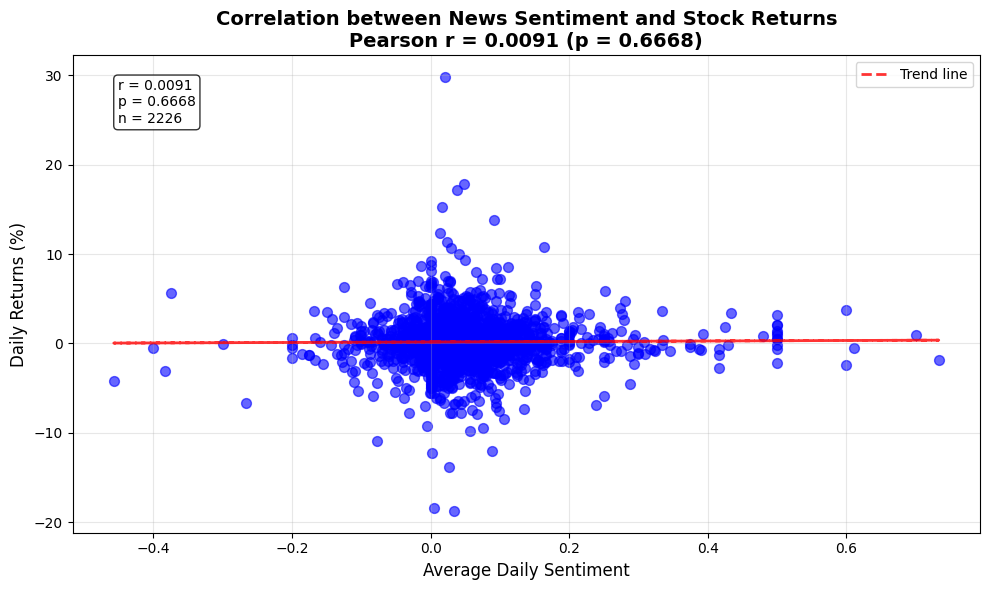

Correlation visualization completed


In [11]:
# Create visualization to show correlation
print("Creating correlation visualization...")

plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(merged_data['avg_sentiment'], merged_data['daily_return'], 
           alpha=0.6, s=50, color='blue')

# Add trend line
z = np.polyfit(merged_data['avg_sentiment'], merged_data['daily_return'], 1)
p = np.poly1d(z)
plt.plot(merged_data['avg_sentiment'], p(merged_data['avg_sentiment']), 
         "r--", linewidth=2, alpha=0.8, label='Trend line')

# Plot formatting
plt.xlabel('Average Daily Sentiment', fontsize=12)
plt.ylabel('Daily Returns (%)', fontsize=12)
plt.title(f'Correlation between News Sentiment and Stock Returns\nPearson r = {correlation:.4f} (p = {p_value:.4f})', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add correlation annotation
plt.annotate(f'r = {correlation:.4f}\np = {p_value:.4f}\nn = {len(merged_data)}', 
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             fontsize=10, ha='left', va='top')

plt.tight_layout()
plt.show()

print("Correlation visualization completed")

In [12]:
# Save results and visualization
print("Saving results...")

# Save merged data
merged_data.to_csv('../data/correlation_results.csv', index=False)
print("✓ Merged data saved to: ../data/correlation_results.csv")

# Save visualization
plt.savefig('../results/correlation_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to: ../results/correlation_analysis.png")

# Save correlation results summary
correlation_summary = pd.DataFrame({
    'metric': ['pearson_correlation', 'p_value', 'sample_size', 'date_range_start', 'date_range_end'],
    'value': [correlation, p_value, len(merged_data), 
              merged_data['date_normalized'].min(), 
              merged_data['date_normalized'].max()]
})
correlation_summary.to_csv('../results/correlation_summary.csv', index=False)
print("✓ Correlation summary saved to: ../results/correlation_summary.csv")

Saving results...
✓ Merged data saved to: ../data/correlation_results.csv
✓ Visualization saved to: ../results/correlation_analysis.png
✓ Correlation summary saved to: ../results/correlation_summary.csv


<Figure size 640x480 with 0 Axes>

In [13]:
# Completion Report
print("\n" + "="*70)
print("CORRELATION ANALYSIS - COMPLETION REPORT")
print("="*70)

print("\n✅ CRITERIA IMPLEMENTATION STATUS:")
print("✓ Normalizing dates between news and stock data - COMPLETED")
print("✓ Performing sentiment analysis on news headlines - COMPLETED") 
print("✓ Computing daily returns - COMPLETED")
print("✓ Calculating Pearson correlation coefficient - COMPLETED")

print(f"\n📊 ANALYSIS RESULTS:")
print(f"   • News articles analyzed: {len(news_df):,}")
print(f"   • Stock trading days: {len(stock_df):,}")
print(f"   • Matching days for correlation: {len(merged_data):,}")
print(f"   • Pearson Correlation Coefficient: {correlation:.4f}")
print(f"   • P-value: {p_value:.4f}")

print(f"\n📈 SENTIMENT ANALYSIS:")
print(f"   • Average headline sentiment: {news_df['sentiment'].mean():.4f}")
print(f"   • Daily average sentiment range: {daily_sentiment['avg_sentiment'].min():.4f} to {daily_sentiment['avg_sentiment'].max():.4f}")

print(f"\n💹 STOCK RETURNS:")
print(f"   • Average daily return: {stock_returns['daily_return'].mean():.4f}%")
print(f"   • Returns range: {stock_returns['daily_return'].min():.4f}% to {stock_returns['daily_return'].max():.4f}%")

print(f"\n🔍 CORRELATION INTERPRETATION:")
if p_value < 0.05:
    if correlation > 0:
        print("   • Statistically significant POSITIVE correlation found")
        print("   • Higher news sentiment tends to associate with higher stock returns")
    else:
        print("   • Statistically significant NEGATIVE correlation found")
        print("   • Higher news sentiment tends to associate with lower stock returns")
else:
    print("   • No statistically significant correlation found")
    print("   • News sentiment and stock returns show no clear relationship")

print(f"\n💾 OUTPUT FILES GENERATED:")
print("   ✓ ../data/correlation_results.csv")
print("   ✓ ../results/correlation_analysis.png") 
print("   ✓ ../results/correlation_summary.csv")

print("\n" + "="*70)
print("SUCCESSFULLY COMPLETED")
print("="*70)


CORRELATION ANALYSIS - COMPLETION REPORT

✅ CRITERIA IMPLEMENTATION STATUS:
✓ Normalizing dates between news and stock data - COMPLETED
✓ Performing sentiment analysis on news headlines - COMPLETED
✓ Computing daily returns - COMPLETED
✓ Calculating Pearson correlation coefficient - COMPLETED

📊 ANALYSIS RESULTS:
   • News articles analyzed: 1,407,328
   • Stock trading days: 3,774
   • Matching days for correlation: 2,226
   • Pearson Correlation Coefficient: 0.0091
   • P-value: 0.6668

📈 SENTIMENT ANALYSIS:
   • Average headline sentiment: 0.0491
   • Daily average sentiment range: -1.0000 to 1.0000

💹 STOCK RETURNS:
   • Average daily return: 0.1877%
   • Returns range: -18.7558% to 29.8067%

🔍 CORRELATION INTERPRETATION:
   • No statistically significant correlation found
   • News sentiment and stock returns show no clear relationship

💾 OUTPUT FILES GENERATED:
   ✓ ../data/correlation_results.csv
   ✓ ../results/correlation_analysis.png
   ✓ ../results/correlation_summary.csv

